In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import optuna

In [39]:
# Modelling Libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation & CV Libraries
from sklearn.metrics import precision_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, StratifiedKFold, cross_val_score, KFold

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

In [3]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

In [5]:
# Each entry of the flights.csv file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

# YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
# AIRLINE: An identification number assigned by US DOT to identify a unique airline
# ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports
# SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing
# DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place
# DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times



### The main goal of this project is to predict arrival delay

In [6]:
# I remove Nans from columns where flights were cancelled (or diverted)
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)
# I remove columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# I remove columns with insufficient data
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [7]:
# In the initial dataframe, dates are coded according to 4 variables: YEAR, MONTH, DAY, and DAY_OF_WEEK. 
# I change it into datetime format:
import datetime
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
# I'll need name of the week and month name
df['DAY_NAME'] = df['DATE'].dt.day_name()
df['MONTH_NAME'] = df['DATE'].dt.month_name()
# I remove those 4 unnecessary columns
df.drop(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK'], axis=1, inplace=True)

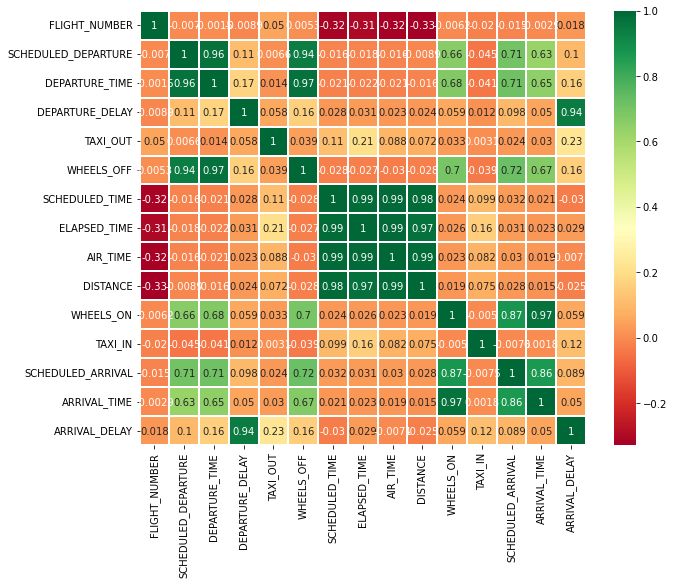

In [7]:
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

### Departure_delay column is the most correlated data with arrival_delay, but I want to predict arrival delays before the flight.

In [8]:
# My goal is to predict if the arrival will be delayed or not, that's why I removed columns that have nothing to do with the goal:
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'DEPARTURE_DELAY', 'DEPARTURE_TIME',
             'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME'], axis=1, inplace=True)

In [9]:
df.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME
771787,EV,CLE,BOS,1634,108.0,563,1822,-5.0,2015-02-20,Friday,February
858015,OO,DEN,MAF,955,105.0,563,1240,39.0,2015-02-26,Thursday,February
4740474,OO,12266,11433,1037,173.0,1075,1430,-23.0,2015-10-23,Friday,October
439281,OO,SFO,AUS,1848,199.0,1504,7,9.0,2015-01-29,Thursday,January
5439155,UA,LAX,DEN,1304,139.0,862,1623,0.0,2015-12-07,Monday,December
1769344,DL,MIA,JFK,1520,189.0,1089,1829,66.0,2015-04-23,Thursday,April
3294512,OO,ORD,SLC,800,210.0,1250,1030,-2.0,2015-07-25,Saturday,July
5032904,EV,JAN,ORD,730,135.0,677,945,-27.0,2015-11-11,Wednesday,November
18833,OO,SNA,DEN,1004,135.0,846,1319,10.0,2015-01-02,Friday,January
5396931,EV,EWR,AVL,1430,117.0,583,1627,10.0,2015-12-04,Friday,December


In [10]:
# SCHEDULED_DEPARTURE and _ARRIVAL - this columns shows hours and minutes from departures and arrivals
# I'm changing it into full hours
df['SCHEDULED_DEPARTURE_H'] = df['SCHEDULED_DEPARTURE'] // 100
df['SCHEDULED_ARRIVAL_H'] = df['SCHEDULED_ARRIVAL'] // 100
# Remove column SCHEDULED_DEPARTURE:
df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1, inplace=True)

# In the data there was one position with hour = 24 (should be 00)
df['SCHEDULED_ARRIVAL_H'].replace(24, 0, inplace=True)

## An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [11]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [12]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [13]:
# Chcking the Nan values
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [14]:
# taking real world data for missing values:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [15]:
# In airports.csv we have airports only from one country - USA
airports['COUNTRY'].value_counts()

USA    322
Name: COUNTRY, dtype: int64

In [16]:
# In airports.csv we have airports from 54 states of USA
airports['STATE'].unique().shape

(54,)

In [17]:
# In the dataframe there are also airports that are not in the airport.csv file
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [11]:
# I remove the data where airports are shown in 5-digit code
df_air= df[df['ORIGIN_AIRPORT'] > 'AAA']
df_air.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AIRLINE                5231130 non-null  object        
 1   ORIGIN_AIRPORT         5231130 non-null  object        
 2   DESTINATION_AIRPORT    5231130 non-null  object        
 3   SCHEDULED_TIME         5231130 non-null  float64       
 4   DISTANCE               5231130 non-null  int64         
 5   ARRIVAL_DELAY          5231130 non-null  float64       
 6   DATE                   5231130 non-null  datetime64[ns]
 7   DAY_NAME               5231130 non-null  object        
 8   MONTH_NAME             5231130 non-null  object        
 9   SCHEDULED_DEPARTURE_H  5231130 non-null  int64         
 10  SCHEDULED_ARRIVAL_H    5231130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 478.9+ MB


## An additional file of this dataset, the airlines.csv file, gives a more exhaustive description of the airlines:

In [19]:
airlines_names=pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [20]:
# I create a dictionary with IATA_CODE and AIRLINE name
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

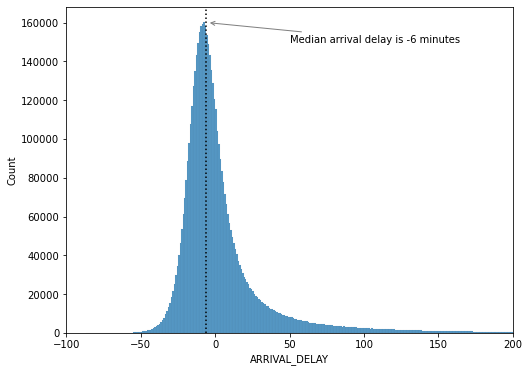

In [16]:
plt.figure(figsize=(8,6))
ax = sns.histplot(x='ARRIVAL_DELAY', data=df_air, binwidth=1)
ax.axvline(x=-6, linestyle='dotted', color='black')
ax.annotate('Median arrival delay is -6 minutes', xy=[-5,160000], 
           xytext=[50, 150000],
           arrowprops={'arrowstyle': '->', 'color':'gray'})
plt.xlim(-100, 200)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\7107336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air["delayed"] = pd.cut( x=df_air["ARRIVAL_DELAY"], bins=[-100, 0, np.inf], labels=[0, 1])


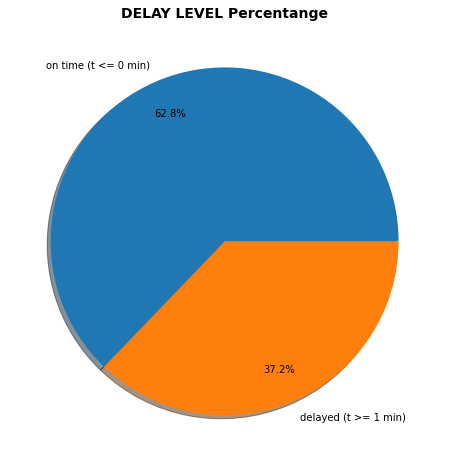

In [12]:
# Function that define how delays are grouped
df_air["delayed"] = pd.cut( x=df_air["ARRIVAL_DELAY"], bins=[-100, 0, np.inf], labels=[0, 1])

# 
delay_level = dict(df_air.groupby('delayed')['delayed'].count())
labels = ['on time (t <= 0 min)', 'delayed (t >= 1 min)']
values = delay_level.values()
plt.figure(figsize=(8,8))
plt.pie(data=df_air, x=values, labels= labels, autopct = '%1.1f%%', pctdistance=0.8, shadow=True)
plt.title('DELAY LEVEL Percentange', fontsize=14, weight = 'bold')
plt.show()

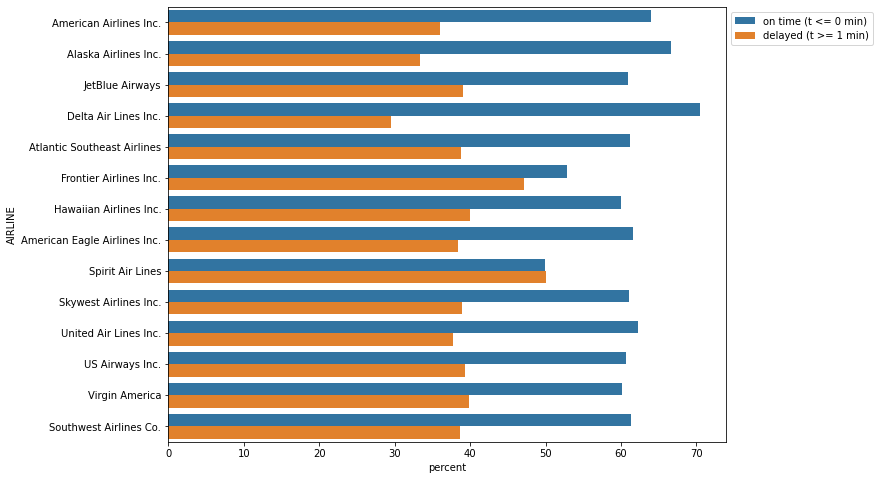

In [23]:
df1 = df_air.groupby('AIRLINE')['delayed'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1['AIRLINE'] = df1['AIRLINE'].replace(abbr_companies)

plt.figure(figsize=(10,8))
sns.barplot(y='AIRLINE', x='percent', hue='level_1', data=df1)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

## Time charts

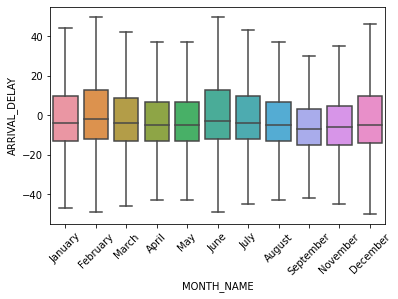

In [39]:
# Boxplot:  Month name vs arrival_delay
sns.boxplot(x='MONTH_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.xticks(rotation=45)
plt.show()

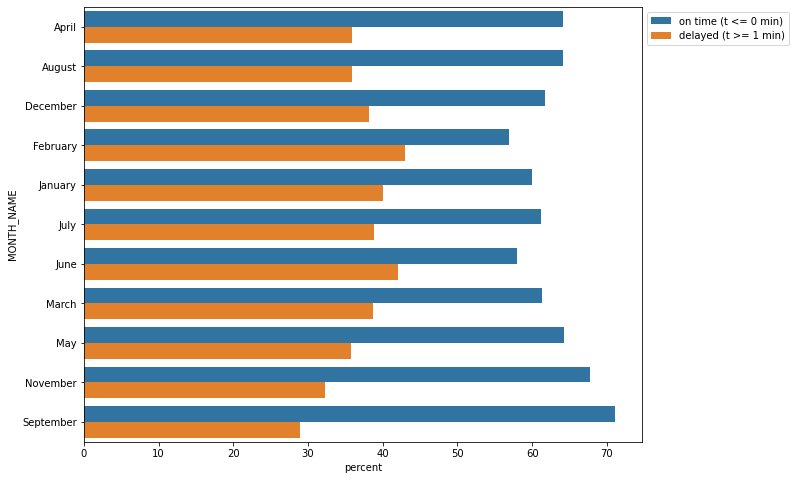

In [24]:
# Bar chart: Flight count delays vs month name

x,y =  'MONTH_NAME', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(10,8))
sns.barplot(y='MONTH_NAME', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

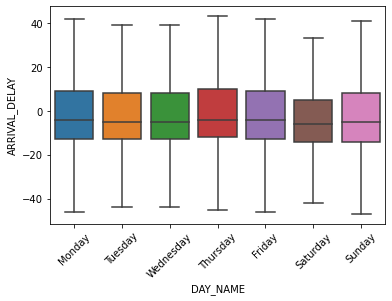

In [43]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='DAY_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False, order=weekdays)
plt.xticks(rotation=45)
plt.show()

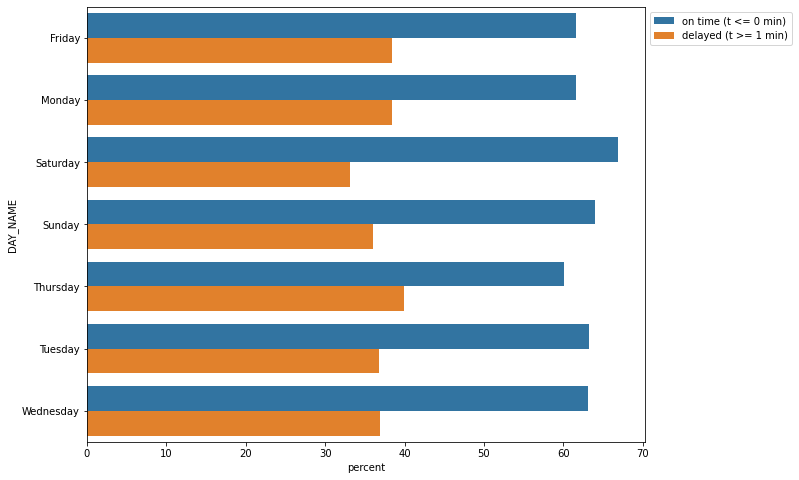

In [25]:
# Bar chart: Flight count delays vs week name

x,y =  'DAY_NAME', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(10,8))
sns.barplot(y='DAY_NAME', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_11484\527070438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['DAY_TYPE'] = df['DAY_NAME'].replace(mappings)


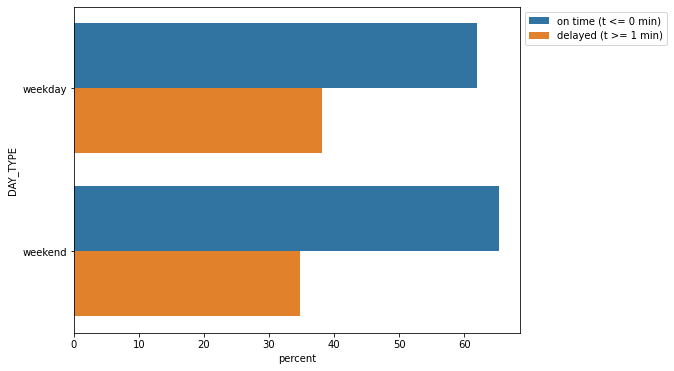

In [16]:
mappings = { 'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday':'weekday', 'Thursday':'weekday',
           'Friday':'weekday', 'Saturday':'weekend', 'Sunday':'weekend'}

df_air['DAY_TYPE'] = df['DAY_NAME'].replace(mappings)

x,y =  'DAY_TYPE', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(8,6))
sns.barplot(y='DAY_TYPE', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()


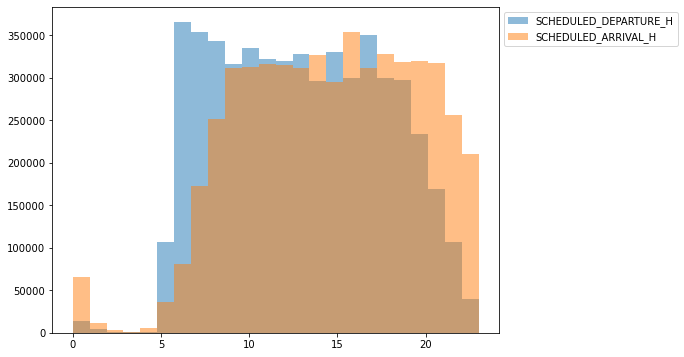

In [45]:
fig, ax=plt.subplots(figsize=(8,6))
ax.hist(df_air['SCHEDULED_DEPARTURE_H'], label='SCHEDULED_DEPARTURE_H', alpha=0.5, bins=24)
ax.hist(df_air['SCHEDULED_ARRIVAL_H'], label='SCHEDULED_ARRIVAL_H', alpha=0.5, bins=24)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

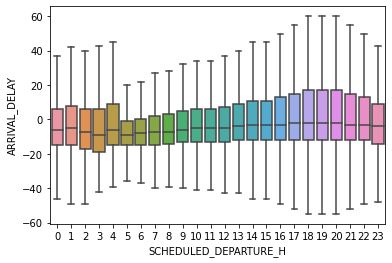

In [46]:
sns.boxplot(x='SCHEDULED_DEPARTURE_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

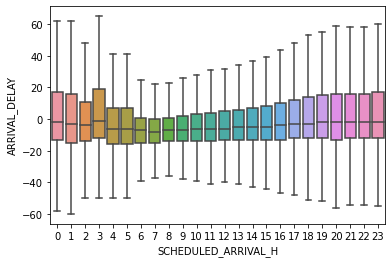

In [47]:
sns.boxplot(x='SCHEDULED_ARRIVAL_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

In [34]:
# Now, I'll check size of airports, by counting the departures:
airport_size = df_air.groupby('ORIGIN_AIRPORT').agg(count=('ORIGIN_AIRPORT', 'size'), 
                                             mean_delay=('ARRIVAL_DELAY', 'mean')).reset_index()
airport_size['size'] = pd.cut(airport_size['count'], bins=[0, 750, 2500, 10000, 25000, 500000],
                              labels=['very small', 'small', 'medium','big','huge'])
airport_size

,ORIGIN_AIRPORT,count,mean_delay,size
0,ABE,2227,6.249663,small
1,ABI,2231,3.272075,small
2,ABQ,18918,4.768263,big
3,ABR,663,9.909502,very small
4,ABY,866,7.587760,small
...,...,...,...,...
317,WRG,649,4.667180,very small
318,WYS,208,-1.865385,very small
319,XNA,8963,11.233850,medium
320,YAK,650,-5.632308,very small


In [35]:
airport_size['size'].value_counts()

medium        86
small         84
very small    76
huge          47
big           29
Name: size, dtype: int64

<AxesSubplot:xlabel='size', ylabel='mean_delay'>

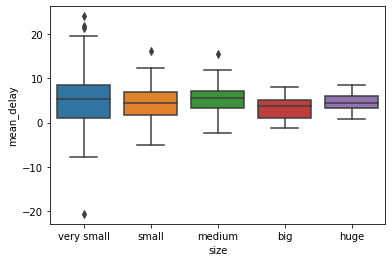

In [36]:
sns.boxplot(x='size', y='mean_delay', data=airport_size)

In [26]:
df3 = df_air.loc[:, ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']]
df4 = df3.merge(airports, how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

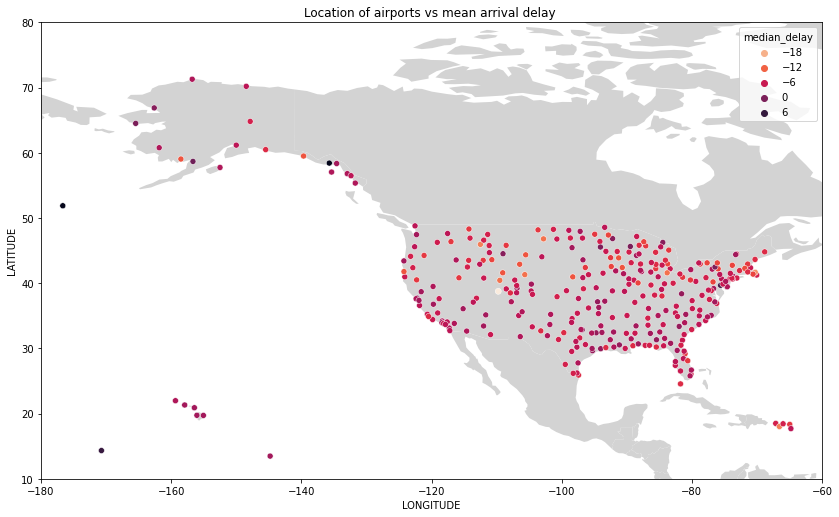

In [28]:
delay_map_dep = df4.groupby('ORIGIN_AIRPORT').agg(
                    median_delay=('ARRIVAL_DELAY', 'median'), 
                    LATITUDE=('LATITUDE', 'mean'), LONGITUDE=('LONGITUDE', 'mean'))

# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(14, 9))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Mean_delay data with a color map
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=delay_map_dep, hue='median_delay', palette='rocket_r')
plt.title('Location of airports vs mean arrival delay ', fontsize=12)
plt.xlim([-180, -60])
plt.ylim([10, 80])
plt.show()

In [13]:
# Instead of airport departure name I'll use mean arrival delay [in minutes]
df_air['Origin_airport_median_dalay'] = df_air.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].transform('median')

# Instead of airport arrival name I'll use mean arrival delay [in minutes]
df_air['Destination_airport_median_dalay'] = df_air.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].transform('median')

# Add new column plane_route as a route between airports and I'll check mean arrival delay between them
df_air['plane_route'] = df_air['ORIGIN_AIRPORT'] + '-' + df_air['DESTINATION_AIRPORT']
df_air['route_median_delay'] = df_air.groupby('plane_route')['ARRIVAL_DELAY'].transform('median')
df_air

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\259602420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['Origin_airport_median_dalay'] = df_air.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].transform('median')
C:\Users\HP\AppData\Local\Temp\ipykernel_17008\259602420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['Destination_airport_median_dalay'] = df_air.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].transform('median')
C:\Users\HP\AppData\Local\Temp\ipykernel_17008\259602420.py:8: S

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME,SCHEDULED_DEPARTURE_H,SCHEDULED_ARRIVAL_H,delayed,Origin_airport_median_dalay,Destination_airport_median_dalay,plane_route,route_median_delay
0,AS,ANC,SEA,205.0,1448,-22.0,2015-01-01,Thursday,January,0,4,0,-5.0,-5.0,ANC-SEA,-6.0
1,AA,LAX,PBI,280.0,2330,-9.0,2015-01-01,Thursday,January,0,7,0,-3.0,-4.0,LAX-PBI,5.0
2,US,SFO,CLT,286.0,2296,5.0,2015-01-01,Thursday,January,0,8,1,-4.0,-5.0,SFO-CLT,-6.0
3,AA,LAX,MIA,285.0,2342,-9.0,2015-01-01,Thursday,January,0,8,0,-3.0,-4.0,LAX-MIA,-1.0
4,AS,SEA,ANC,235.0,1448,-21.0,2015-01-01,Thursday,January,0,3,0,-3.0,-4.0,SEA-ANC,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,B6,LAX,BOS,320.0,2611,-26.0,2015-12-31,Thursday,December,23,8,0,-3.0,-5.0,LAX-BOS,-7.0
5819075,B6,JFK,PSE,227.0,1617,-16.0,2015-12-31,Thursday,December,23,4,0,-7.0,0.0,JFK-PSE,3.0
5819076,B6,JFK,SJU,221.0,1598,-8.0,2015-12-31,Thursday,December,23,4,0,-7.0,-3.0,JFK-SJU,-6.0
5819077,B6,MCO,SJU,161.0,1189,-10.0,2015-12-31,Thursday,December,23,3,0,-5.0,-3.0,MCO-SJU,-1.0


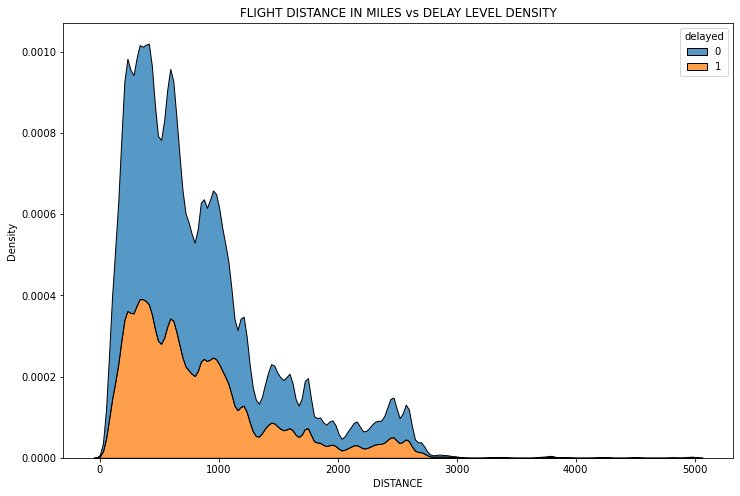

In [30]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='DISTANCE', hue='delayed', data=df_air, multiple="stack")
plt.title('FLIGHT DISTANCE IN MILES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

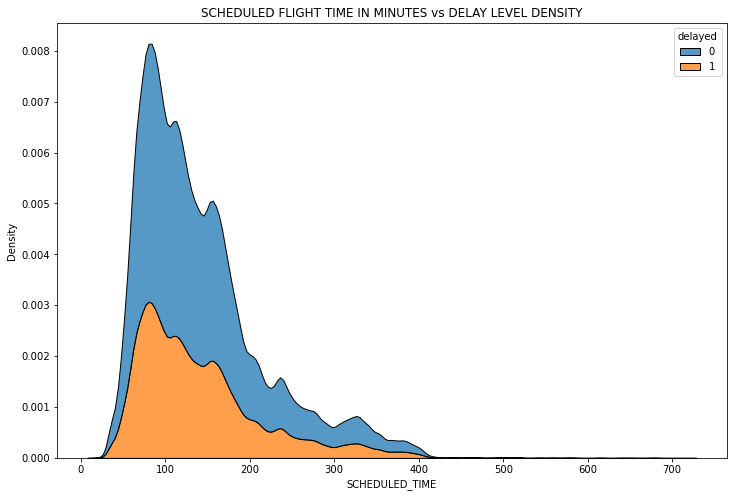

In [31]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='SCHEDULED_TIME', hue='delayed', data=df_air, multiple="stack")
plt.title('SCHEDULED FLIGHT TIME IN MINUTES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

## Model 1 (whole dataset)

In [32]:
df_air.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_3452\1636373088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)


In [33]:
df_ohe = pd.get_dummies(data=df_air, columns=['AIRLINE', 'DAY_NAME', 'MONTH_NAME'])

In [34]:
df_ohe.shape

(5231130, 40)

In [35]:
y=df_ohe.pop('delayed')
X=df_ohe

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [49]:
X_train.shape

(4184904, 39)

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)  # ok. 8 min
xgb.fit(X_train, y_train)
xgb_results_train = xgb.predict(X_train)
xgb_results_test = xgb.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, xgb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, xgb_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, xgb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, xgb_results_test)))

Balanced accuracy score in train set: 0.573
Balanced accuracy score in test set: 0.572
Accuracy score in train set: 0.657
Accuracy score in test set: 0.656


In [46]:
print(classification_report(y_test, xgb_results_test))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77    656933
           1       0.59      0.25      0.35    389293

    accuracy                           0.66   1046226
   macro avg       0.63      0.57      0.56   1046226
weighted avg       0.64      0.66      0.61   1046226



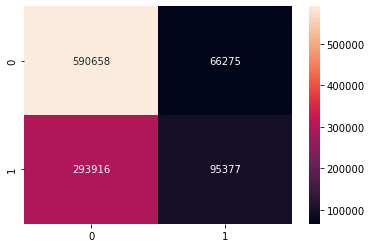

In [47]:
gb_cm=confusion_matrix(y_test, xgb_results_test)
sns.heatmap(gb_cm, annot=True, fmt='d')
plt.show()

In [41]:
lr = LogisticRegression(random_state=1, n_jobs=-1)
lr.fit(X_train, y_train)
lr_results_train = lr.predict(X_train)
lr_results = lr.predict(X_test)
print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, lr_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, lr_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, lr_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, lr_results)))

Accuracy score in train set: 0.638
Accuracy score in test set: 0.639
ROC AUC score in train set: 0.542
ROC AUC score in test set: 0.543


In [66]:
rdg = RidgeClassifier(random_state=1)
rdg.fit(X_train, y_train)
rdg_results_train = rdg.predict(X_train)
rdg_results = rdg.predict(X_test)
print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rdg_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rdg_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rdg_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rdg_results)))

Balanced accuracy score in train set: 0.338
Balanced accuracy score in test set: 0.339
Accuracy score in train set: 0.629
Accuracy score in test set: 0.629


In [42]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_results_train = nb.predict(X_train)
nb_results = nb.predict(X_test)
print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, nb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, nb_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, nb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, nb_results)))

Accuracy score in train set: 0.615
Accuracy score in test set: 0.616
ROC AUC score in train set: 0.561
ROC AUC score in test set: 0.561


In [43]:
dt = DecisionTreeClassifier()   # ok. 2 min.
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results = dt.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.618
ROC AUC score in train set: 0.765
ROC AUC score in test set: 0.564


In [44]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)  # 8 min.
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results = rf.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.616
ROC AUC score in train set: 0.783
ROC AUC score in test set: 0.576


## Model 2 (half of the dataset)

In [14]:
df_6 = df_air[df_air['DATE'] <= '2015-06-30']
df_6.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_18124\2097014546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)


In [15]:
df_ohe1 = pd.get_dummies(data=df_6, columns=['AIRLINE', 'DAY_NAME', 'MONTH_NAME'])

In [16]:
y=df_ohe1.pop('delayed')
X=df_ohe1

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
lr = LogisticRegression(random_state=1, n_jobs=-1)
lr.fit(X_train, y_train)
lr_results_train = lr.predict(X_train)
lr_results = lr.predict(X_test)
print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, lr_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, lr_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, lr_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, lr_results)))

Accuracy score in train set: 0.623
Accuracy score in test set: 0.624
ROC AUC score in train set: 0.548
ROC AUC score in test set: 0.550


In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results_test = dt.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test)))

Accuracy score in train set: 0.805
Accuracy score in test set: 0.607
ROC AUC score in train set: 0.771
ROC AUC score in test set: 0.564


In [24]:
print(classification_report(y_test, dt_results_test))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70    342560
           1       0.50      0.37      0.42    221151

    accuracy                           0.61    563711
   macro avg       0.57      0.56      0.56    563711
weighted avg       0.59      0.61      0.59    563711



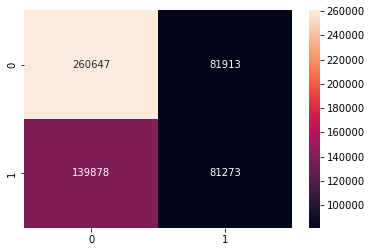

In [25]:
gb_cm=confusion_matrix(y_test, dt_results_test)
sns.heatmap(gb_cm, annot=True, fmt='d')
plt.show()

In [27]:
xgb = XGBClassifier(random_state=1, n_jobs=-1) # 3 min.
xgb.fit(X_train, y_train)
xgb_results_train = xgb.predict(X_train)
xgb_results_test = xgb.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, xgb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, xgb_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, xgb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, xgb_results_test)))

Accuracy score in train set: 0.647
Accuracy score in test set: 0.645
ROC AUC score in train set: 0.585
ROC AUC score in test set: 0.583


In [28]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_results_train = nb.predict(X_train)
nb_results = nb.predict(X_test)
print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, nb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, nb_results)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, nb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, nb_results)))

Accuracy score in train set: 0.611
Accuracy score in test set: 0.610
ROC AUC score in train set: 0.556
ROC AUC score in test set: 0.557


In [29]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results_test = rf.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test)))

Accuracy score in train set: 0.805
Accuracy score in test set: 0.604
ROC AUC score in train set: 0.787
ROC AUC score in test set: 0.575


In [30]:
print(classification_report(y_test, dt_results_test))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70    342560
           1       0.50      0.37      0.42    221151

    accuracy                           0.61    563711
   macro avg       0.57      0.56      0.56    563711
weighted avg       0.59      0.61      0.59    563711



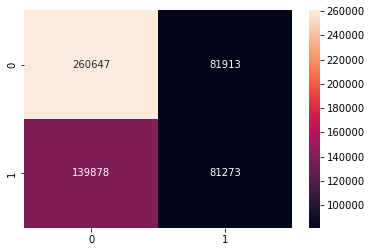

In [31]:
gb_cm=confusion_matrix(y_test, dt_results_test)
sns.heatmap(gb_cm, annot=True, fmt='d')
plt.show()

## Model 2 z walidacją

In [18]:
df_6 = df_air[df_air['DATE'] <= '2015-06-30']
df_6.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_11484\2097014546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], axis=1, inplace=True)


In [19]:
df_ohe2 = pd.get_dummies(data=df_6, columns=['AIRLINE', 'DAY_NAME', 'MONTH_NAME', 'DAY_TYPE'])
df_ohe2.shape

(2818553, 37)

In [21]:
y=df_ohe2.pop('delayed')
X=df_ohe2

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results_val = dt.predict(X_val)
dt_results_test = dt.predict(X_test)

print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in val set: {:.3f}'.format(roc_auc_score(y_val, dt_results_val)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test)))

ROC AUC score in train set: 0.771
ROC AUC score in val set: 0.564
ROC AUC score in test set: 0.564


In [27]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results_val = dt.predict(X_val)
rf_results_test = rf.predict(X_test)

print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in val set: {:.3f}'.format(roc_auc_score(y_val, rf_results_val)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test)))

ROC AUC score in train set: 0.787
ROC AUC score in val set: 0.564
ROC AUC score in test set: 0.575


## Model 3

In [19]:
df_6 = df_air[df_air['DATE'] <= '2015-06-30']
df_6.drop(['ARRIVAL_DELAY', 'DATE'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_17872\3164434127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6.drop(['ARRIVAL_DELAY', 'DATE'], axis=1, inplace=True)


In [21]:
df_ohe3 = pd.get_dummies(data=df_6, columns=['AIRLINE', 'DAY_NAME', 'MONTH_NAME', 'ORIGIN_AIRPORT',
                                             'DESTINATION_AIRPORT'])
df_ohe3.shape

(2818553, 676)

In [22]:
y=df_ohe3.pop('delayed')
X=df_ohe3

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
dt = DecisionTreeClassifier()   # 5 min
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results_test = dt.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test)))

Accuracy score in train set: 0.811
Accuracy score in test set: 0.607
ROC AUC score in train set: 0.778
ROC AUC score in test set: 0.565


In [30]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [33]:
skf = StratifiedKFold()         # 1h i błąd
print('StratifiedKFold cross validation score:{:.3f}'.format(cross_val_score(dt, X, y, cv=skf)))

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [34]:
scores = cross_val_score(dt, X, y)            # 1h i błąd
print('Cross validation score:{:.3f}'.format(scores))

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [36]:
dt = DecisionTreeClassifier()     #  wyłączam po 3h
param_gridDT = {'max_depth':list(range(5,10)), 'random_state': [1]}

clf_dt = GridSearchCV(dt, param_gridDT, cv=5)
clf_dt.fit(X_train, y_train)

KeyboardInterrupt: 

In [26]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1) # 30 min
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results_test = rf.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test)))

Accuracy score in train set: 0.811
Accuracy score in test set: 0.606
ROC AUC score in train set: 0.794
ROC AUC score in test set: 0.577


## Model 4.1 (sam styczeń)

In [14]:
df_1 = df_air[df_air['DATE'] <= '2015-01-31']

In [16]:
df_1.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'], 
                  axis=1, inplace=True)

KeyError: "['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'plane_route'] not found in axis"

In [21]:
df_111 = pd.get_dummies(data=df_1, columns=['AIRLINE', 'DAY_NAME', 'MONTH_NAME'])
df_111.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457013 entries, 0 to 469967
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   SCHEDULED_TIME                    457013 non-null  float64 
 1   DISTANCE                          457013 non-null  int64   
 2   SCHEDULED_DEPARTURE_H             457013 non-null  int64   
 3   SCHEDULED_ARRIVAL_H               457013 non-null  int64   
 4   delayed                           457013 non-null  category
 5   Origin_airport_median_dalay       457013 non-null  float64 
 6   Destination_airport_median_dalay  457013 non-null  float64 
 7   route_median_delay                457013 non-null  float64 
 8   AIRLINE_AA                        457013 non-null  uint8   
 9   AIRLINE_AS                        457013 non-null  uint8   
 10  AIRLINE_B6                        457013 non-null  uint8   
 11  AIRLINE_DL                        45701

In [22]:
df_111.drop('MONTH_NAME_January', axis=1, inplace=True)

In [24]:
y=df_111.pop('delayed')
X=df_111

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results_test = dt.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.598
ROC AUC score in train set: 0.778
ROC AUC score in test set: 0.557


In [30]:
dt = DecisionTreeClassifier()
param_gridDT = {'max_depth':list(range(5,11)), 'random_state': [1], 'criterion':["gini", "entropy", "log_loss"]}

clf_dt = GridSearchCV(dt, param_gridDT, cv=5)
clf_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'random_state': [1]})

In [31]:
print('Best score: {}'.format(clf_dt.best_estimator_))
print('Best score: {}'.format(clf_dt.best_score_)) # Mean cross-validated score of the best_estimator

Best score: DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)
Best score: 0.6180164656327781


In [33]:
dt_results_train_gs = clf_dt.best_estimator_.predict(X_train)
dt_results_test_gs = clf_dt.best_estimator_.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train_gs)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results_test_gs)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train_gs)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test_gs)))

Accuracy score in train set: 0.626
Accuracy score in test set: 0.621
ROC AUC score in train set: 0.571
ROC AUC score in test set: 0.567


In [27]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results_test = rf.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.591
ROC AUC score in train set: 0.792
ROC AUC score in test set: 0.563


In [34]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)  # 40 min.
param_gridRF = {'max_depth':list(range(5,10)), 'random_state': [1], 'criterion':["gini", "entropy", "log_loss"], 
               'n_estimators':[50, 100, 200]}

clf_rf = GridSearchCV(rf, param_gridRF, cv=5)
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'n_estimators': [50, 100, 200], 'random_state': [1]})

In [35]:
print('Best score: {}'.format(clf_rf.best_estimator_))
print('Best score: {}'.format(clf_rf.best_score_)) # Mean cross-validated score of the best_estimator

Best score: RandomForestClassifier(max_depth=9, n_estimators=200, n_jobs=-1, random_state=1)
Best score: 0.6219003856568474


In [36]:
rf_results_train_gs = clf_rf.best_estimator_.predict(X_train)
rf_results_test_gs = clf_rf.best_estimator_.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train_gs)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results_test_gs)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train_gs)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test_gs)))

Accuracy score in train set: 0.626
Accuracy score in test set: 0.624
ROC AUC score in train set: 0.551
ROC AUC score in test set: 0.550


In [37]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_results_train = xgb.predict(X_train)
xgb_results_test = xgb.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, xgb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, xgb_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, xgb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, xgb_results_test)))

Accuracy score in train set: 0.653
Accuracy score in test set: 0.641
ROC AUC score in train set: 0.602
ROC AUC score in test set: 0.590


In [38]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'n_jobs': -1,
        'random_state':1,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [39]:
study = optuna.create_study(direction='maximize')

[I 2023-03-18 18:12:38,681] A new study created in memory with name: no-name-9930c5b7-788e-4d78-a4ae-3d5ffc6247c9


In [40]:
study.optimize(objective, n_trials=50) # 18:12 19:04

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:13:56,328] Trial 3 finished with value: 0.598886250998326 and parameters: {'max_depth': 2, 'learning_rate': 0.03007682472171972, 'n_estimators': 58, 'min_child_weight': 9, 'gamma': 0.08271469685751609, 'subsample': 0.21586757263100567, 'colsample_bytree': 0.09322928280703836, 'reg_alpha': 7.061035499428315e-05, 'reg_lambda': 0.6145683250486763}. Best is trial 1 with value: 0.629016553067186.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:17:39,851] Trial 10 finished with value: 0.6076934017483014 and parameters: {'max_depth': 7, 'learning_rate': 0.010950454863328206, 'n_estimators': 402, 'min_child_weight': 4, 'gamma': 1.99845978992944e-08, 'subsample': 0.988372264181993, 'colsample_bytree': 0.1160617688261729, 'reg_alpha': 0.2908205602081503, 'reg_lambda': 0.9734343857863496}. Best is trial 5 with value: 0.6371125674212006.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:27:08,964] Trial 17 finished with value: 0.6425937879500673 and parameters: {'max_depth': 6, 'learning_rate': 0.11168434618981088, 'n_estimators': 351, 'min_child_weight': 3, 'gamma': 7.681262694488627e-07, 'subsample': 0.6859157130478291, 'colsample_bytree': 0.8591418945402359, 'reg_alpha': 1.2860027907663277e-07, 'reg_lambda': 1.635040278931517e-05}. Best is trial 14 with value: 0.6462041727295603.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:35:27,390] Trial 24 finished with value: 0.6404494382022472 and parameters: {'max_depth': 8, 'learning_rate': 0.2761417162194561, 'n_estimators': 448, 'min_child_weight': 2, 'gamma': 1.2024056048472072e-05, 'subsample': 0.6401101954825116, 'colsample_bytree': 0.5739972532986531, 'reg_alpha': 5.461483196076428e-08, 'reg_lambda': 1.050109753634021e-07}. Best is trial 14 with value: 0.6462041727295603.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:43:40,975] Trial 31 finished with value: 0.6450444733761473 and parameters: {'max_depth': 6, 'learning_rate': 0.2527161446214834, 'n_estimators': 397, 'min_child_weight': 3, 'gamma': 2.9720296385089244e-07, 'subsample': 0.9754851658522136, 'colsample_bytree': 0.4496216077306971, 'reg_alpha': 4.379047374339635e-08, 'reg_lambda': 1.0437358298616047e-08}. Best is trial 14 with value: 0.6462041727295603.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 18:51:35,991] Trial 38 finished with value: 0.6371891513407656 and parameters: {'max_depth': 4, 'learning_rate': 0.20311397814244952, 'n_estimators': 447, 'min_child_weight': 10, 'gamma': 0.00016425528671638783, 'subsample': 0.30888985736303565, 'colsample_bytree': 0.31688901917735357, 'reg_alpha': 8.568849466188843e-07, 'reg_lambda': 1.6796288674187134e-07}. Best is trial 34 with value: 0.6466964979267639.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-18 19:00:13,875] Trial 45 finished with value: 0.6414340885966544 and parameters: {'max_depth': 7, 'learning_rate': 0.1420892829258025, 'n_estimators': 325, 'min_child_weight': 5, 'gamma': 2.503090768865572e-08, 'subsample': 0.9706954088299141, 'colsample_bytree': 0.2669374743109345, 'reg_alpha': 2.8559881874234753e-07, 'reg_lambda': 2.4890234056996336e-08}. Best is trial 34 with value: 0.6466964979267639.
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_10276\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

In [41]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.6466964979267639
  Params: 
    max_depth: 7
    learning_rate: 0.2403147821190824
    n_estimators: 458
    min_child_weight: 3
    gamma: 5.443787619988271e-05
    subsample: 0.9872880054967054
    colsample_bytree: 0.41125022228941116
    reg_alpha: 1.3658947685985401e-08
    reg_lambda: 3.444299551227841e-08


## Model 4.2 styczeń + ohe

In [16]:
df_1.drop(['ARRIVAL_DELAY', 'DATE'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_8480\3667236365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(['ARRIVAL_DELAY', 'DATE'], axis=1, inplace=True)


In [18]:
df_1.drop(['MONTH_NAME'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_8480\32044613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(['MONTH_NAME'], axis=1, inplace=True)


In [20]:
df_12 = pd.get_dummies(data=df_1, columns=['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT','AIRLINE', 'DAY_NAME'])
df_12.shape

(457013, 650)

In [21]:
y=df_12.pop('delayed')
X=df_12

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_results_train = dt.predict(X_train)
dt_results_test = dt.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, dt_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, dt_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, dt_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, dt_results_test)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.598
ROC AUC score in train set: 0.778
ROC AUC score in test set: 0.557


In [25]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_results_train = rf.predict(X_train)
rf_results_test = rf.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, rf_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, rf_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, rf_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, rf_results_test)))

Accuracy score in train set: 0.808
Accuracy score in test set: 0.592
ROC AUC score in train set: 0.792
ROC AUC score in test set: 0.564


In [26]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_results_train = xgb.predict(X_train)
xgb_results_test = xgb.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, xgb_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, xgb_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, xgb_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, xgb_results_test)))

Accuracy score in train set: 0.651
Accuracy score in test set: 0.641
ROC AUC score in train set: 0.597
ROC AUC score in test set: 0.587


In [27]:
models =[("LR", LogisticRegression(random_state=1)), ('ADA',AdaBoostClassifier(random_state=1)), 
         ("GNB", GaussianNB()), ("Ridge", RidgeClassifier(random_state=1)), ("SGD", SGDClassifier(random_state=1))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = roc_auc_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults

NameError: name 'finakResults' is not defined

In [28]:
finalResults  # ROC_AUC_SCORE on test set

[('LR', 0.5691880106567803),
 ('Ridge', 0.568110941611981),
 ('ADA', 0.5534857684958053),
 ('GNB', 0.5507969029373792),
 ('SGD', 0.5358185448199053)]

In [29]:
results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = accuracy_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults   # Accuracy score on test set

[('Ridge', 0.6255155738870716),
 ('LR', 0.6251873570889358),
 ('ADA', 0.616030108420949),
 ('SGD', 0.6067525135936457),
 ('GNB', 0.5243153944618886)]

## Model 5 other months

In [14]:
# February
df_2 = df_air[df_air['MONTH_NAME'] == 'February']

In [16]:
df_2.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'], 
                  axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\4685587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'],


In [18]:
df_21 = pd.get_dummies(data=df_2, columns=['AIRLINE', 'DAY_NAME'])
df_21.shape

(407663, 29)

In [19]:
y=df_21.pop('delayed')
X=df_21

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
models =[("LR", LogisticRegression(random_state=1)), ('ADA',AdaBoostClassifier(random_state=1)), 
         ("XGB", XGBClassifier(random_state=1)), ("DTC", DecisionTreeClassifier()), 
         ('RF',RandomForestClassifier(random_state=1)), ("GNB", GaussianNB()),
        ("Ridge", RidgeClassifier(random_state=1)), ("SGD", SGDClassifier(random_state=1))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = roc_auc_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults   # ROC_AUC_SCORE on test set

[('XGB', 0.5997984193304148),
 ('ADA', 0.5692880851078335),
 ('LR', 0.5649367714674083),
 ('Ridge', 0.5638563965262946),
 ('RF', 0.5628759500197094),
 ('GNB', 0.5587660910682387),
 ('DTC', 0.5524745144601161),
 ('SGD', 0.5390688382086329)]

In [22]:
models =[("LR", LogisticRegression(random_state=1)), ('ADA',AdaBoostClassifier(random_state=1)), 
         ("XGB", XGBClassifier(random_state=1)), ("DTC", DecisionTreeClassifier()), 
         ('RF',RandomForestClassifier(random_state=1)), ("GNB", GaussianNB()),
        ("Ridge", RidgeClassifier(random_state=1)), ("SGD", SGDClassifier(random_state=1))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = accuracy_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults   # ACC score on test set

[('XGB', 0.6276722308758417),
 ('ADA', 0.6044546379993377),
 ('LR', 0.6019035237265893),
 ('Ridge', 0.6015723694700306),
 ('GNB', 0.5973900138594189),
 ('SGD', 0.5904112445267561),
 ('RF', 0.5746998147989157),
 ('DTC', 0.5737922068364957)]

In [ ]:
models = {'RF':RandomForestClassifier(), "LR":LogisticRegression(), "Ridge":RidgeClassifier(), 
          'ADA':AdaBoostClassifier(), 'XGB':XGBClassifier()}

results_cv = []
for model in models.values():
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)   #  8 min.
    results_cv.append(cv_results)

In [46]:
# March
df_3 = df_air[df_air['MONTH_NAME'] == 'March']
df_3.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'], 
                  axis=1, inplace=True)
df_31 = pd.get_dummies(data=df_3, columns=['AIRLINE', 'DAY_NAME'])
df_31.shape

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\184614804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'],


(492138, 29)

In [47]:
y=df_31.pop('delayed')
X=df_31

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = roc_auc_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults   # ROC_AUC_SCORE on test set

[('XGB', 0.583860597608397),
 ('RF', 0.5723502174824802),
 ('DTC', 0.5639104733838368),
 ('GNB', 0.5496172308973815),
 ('ADA', 0.5467879084971273),
 ('LR', 0.5456903530564006),
 ('Ridge', 0.5429478838545027),
 ('SGD', 0.5060616344649619)]

In [32]:
results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = accuracy_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)
finalResults   # ACC score on test set

[('XGB', 0.6494493436826919),
 ('ADA', 0.6283069858170439),
 ('LR', 0.6272503759092941),
 ('Ridge', 0.6267525500873735),
 ('SGD', 0.6135550859511522),
 ('GNB', 0.610761165522006),
 ('DTC', 0.610740846100703),
 ('RF', 0.6059861015158289)]

In [50]:
models = {'RF':RandomForestClassifier(), "LR":LogisticRegression(), "Ridge":RidgeClassifier(), 
          'ADA':AdaBoostClassifier(), 'XGB':XGBClassifier()}

results_cv = []
for model in models.values():
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=skf)   # 8 min
    results_cv.append(cv_results)

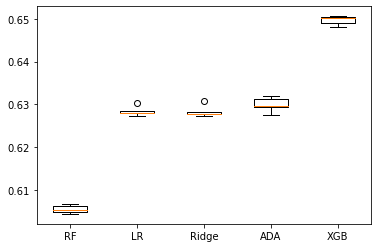

In [51]:
plt.boxplot(results_cv, labels=models.keys())
plt.show()

In [56]:
# April
df_4 = df_air[df_air['MONTH_NAME'] == 'April']
df_4.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'], 
                  axis=1, inplace=True)
df_41 = pd.get_dummies(data=df_4, columns=['AIRLINE', 'DAY_NAME'])

y=df_41.pop('delayed')
X=df_41

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\1283283915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'],


In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
models = {'RF':RandomForestClassifier(), "LR":LogisticRegression(), "Ridge":RidgeClassifier(), 
          'ADA':AdaBoostClassifier(), 'XGB':XGBClassifier()}

results_cv = []
for model in models.values():
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)   #  9 min
    results_cv.append(cv_results)

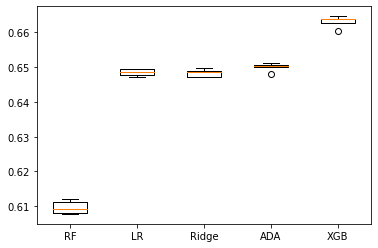

In [59]:
plt.boxplot(results_cv, labels=models.keys())
plt.show()

In [52]:
# May
df_5 = df_air[df_air['MONTH_NAME'] == 'April']
df_5.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'], 
                  axis=1, inplace=True)
df_51 = pd.get_dummies(data=df_5, columns=['AIRLINE', 'DAY_NAME'])

y=df_51.pop('delayed')
X=df_51

C:\Users\HP\AppData\Local\Temp\ipykernel_17008\3268319686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.drop(['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY', 'DATE', 'MONTH_NAME','plane_route'],


In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
models = {'RF':RandomForestClassifier(), "LR":LogisticRegression(), "Ridge":RidgeClassifier(), 
          'ADA':AdaBoostClassifier(), 'XGB':XGBClassifier()}

results_cv = []
for model in models.values():
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=skf)
    results_cv.append(cv_results)

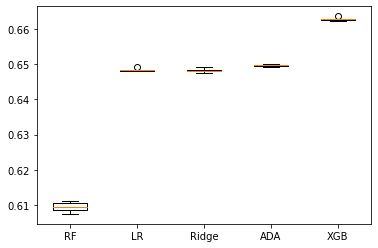

In [55]:
plt.boxplot(results_cv, labels=models.keys())
plt.show()